### Setup 

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# make repo importable
repo_root = Path.cwd()
while repo_root.name != "Coulombic-Efficiency-Driven-Optimization-of-Health-Aware-Charging-Protocols":
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

from utils.soc_sweep_analysis import get_default_groups
from utils.threshold_boundaries import (
    build_ce_dataframe,
    build_summary_dataframe,
    build_soc_table,
    fit_quadratic_boundaries,
)

processed_root = repo_root / "data" / "SOC sweep data (processed)"
groups = get_default_groups()

df_ce = build_ce_dataframe(groups, processed_root)
df_summary = build_summary_dataframe(df_ce, threshold=99.3)



### Scatter Crossing Points per C-Rate

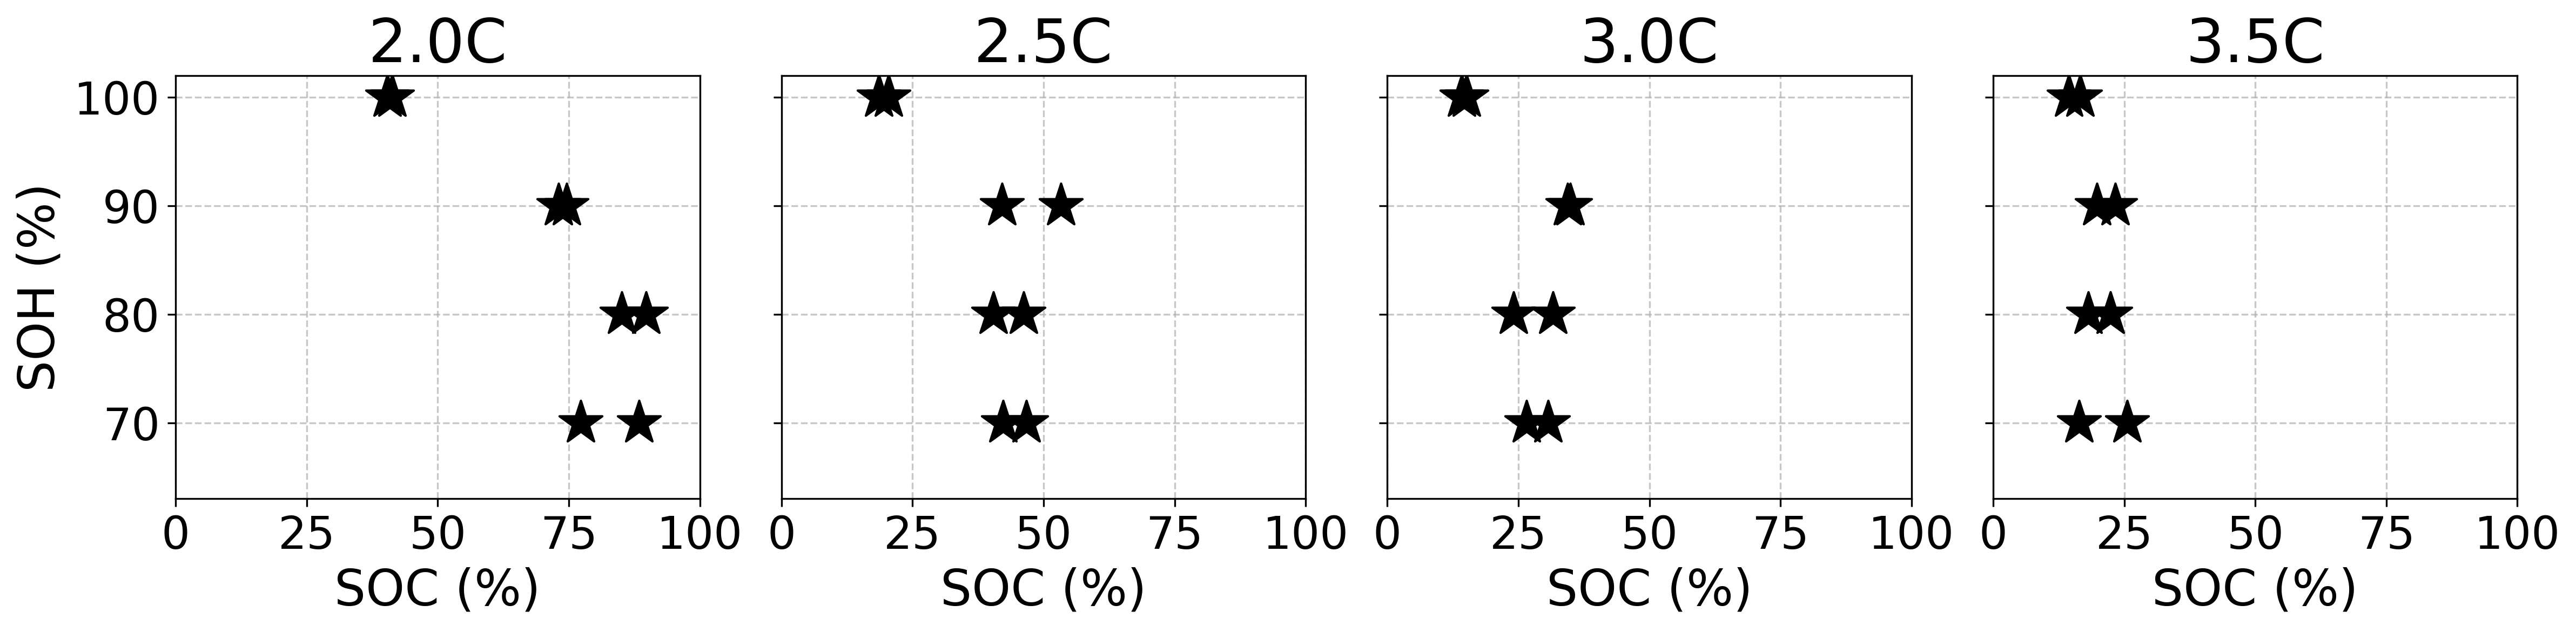

In [3]:
discrete_soh = {"G1": 100, "G2": 90, "G3": 80, "G4": 70}
df_summary["Discrete SOH"] = df_summary["Group"].map(discrete_soh)

df_filtered = df_summary[df_summary["Numeric C-rate"] != 1.5]
unique_c_rates = sorted(df_filtered["Numeric C-rate"].unique())

fig, axes = plt.subplots(
    1, len(unique_c_rates),
    figsize=(4 * len(unique_c_rates), 4),
    sharex=True, sharey=True,
    dpi=300,
)
if len(unique_c_rates) == 1:
    axes = [axes]

for i, (ax, c_rate) in enumerate(zip(axes, unique_c_rates)):
    df_cr = df_filtered[df_filtered["Numeric C-rate"] == c_rate]
    ax.scatter(df_cr["Crossing_SOC"], df_cr["Discrete SOH"], s=400, marker="*", facecolor="k", edgecolor="k", zorder=3)

    ax.set_title(f"{c_rate}C", fontsize=27)
    ax.set_xlabel("SOC (%)", fontsize=22)
    if i == 0:
        ax.set_ylabel("SOH (%)", fontsize=22)

    ax.grid(True, linestyle="--", alpha=0.7)
    ax.tick_params(labelsize=20)
    ax.set_ylim(63, 102)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])

plt.tight_layout()
plt.show()


### Quadratic Interpolation & Final Operating Map

Average SOC values for each C-rate and SOH level:
Discrete SOH          70         80         90         100
Numeric C-rate                                            
2.0             82.825171  87.409307  73.828892  40.872787
2.5             44.489741  43.332062  47.713152  19.523276
3.0             28.600326  27.851803  34.680329  14.648615
3.5             20.959398  20.218483  21.554226  15.527134


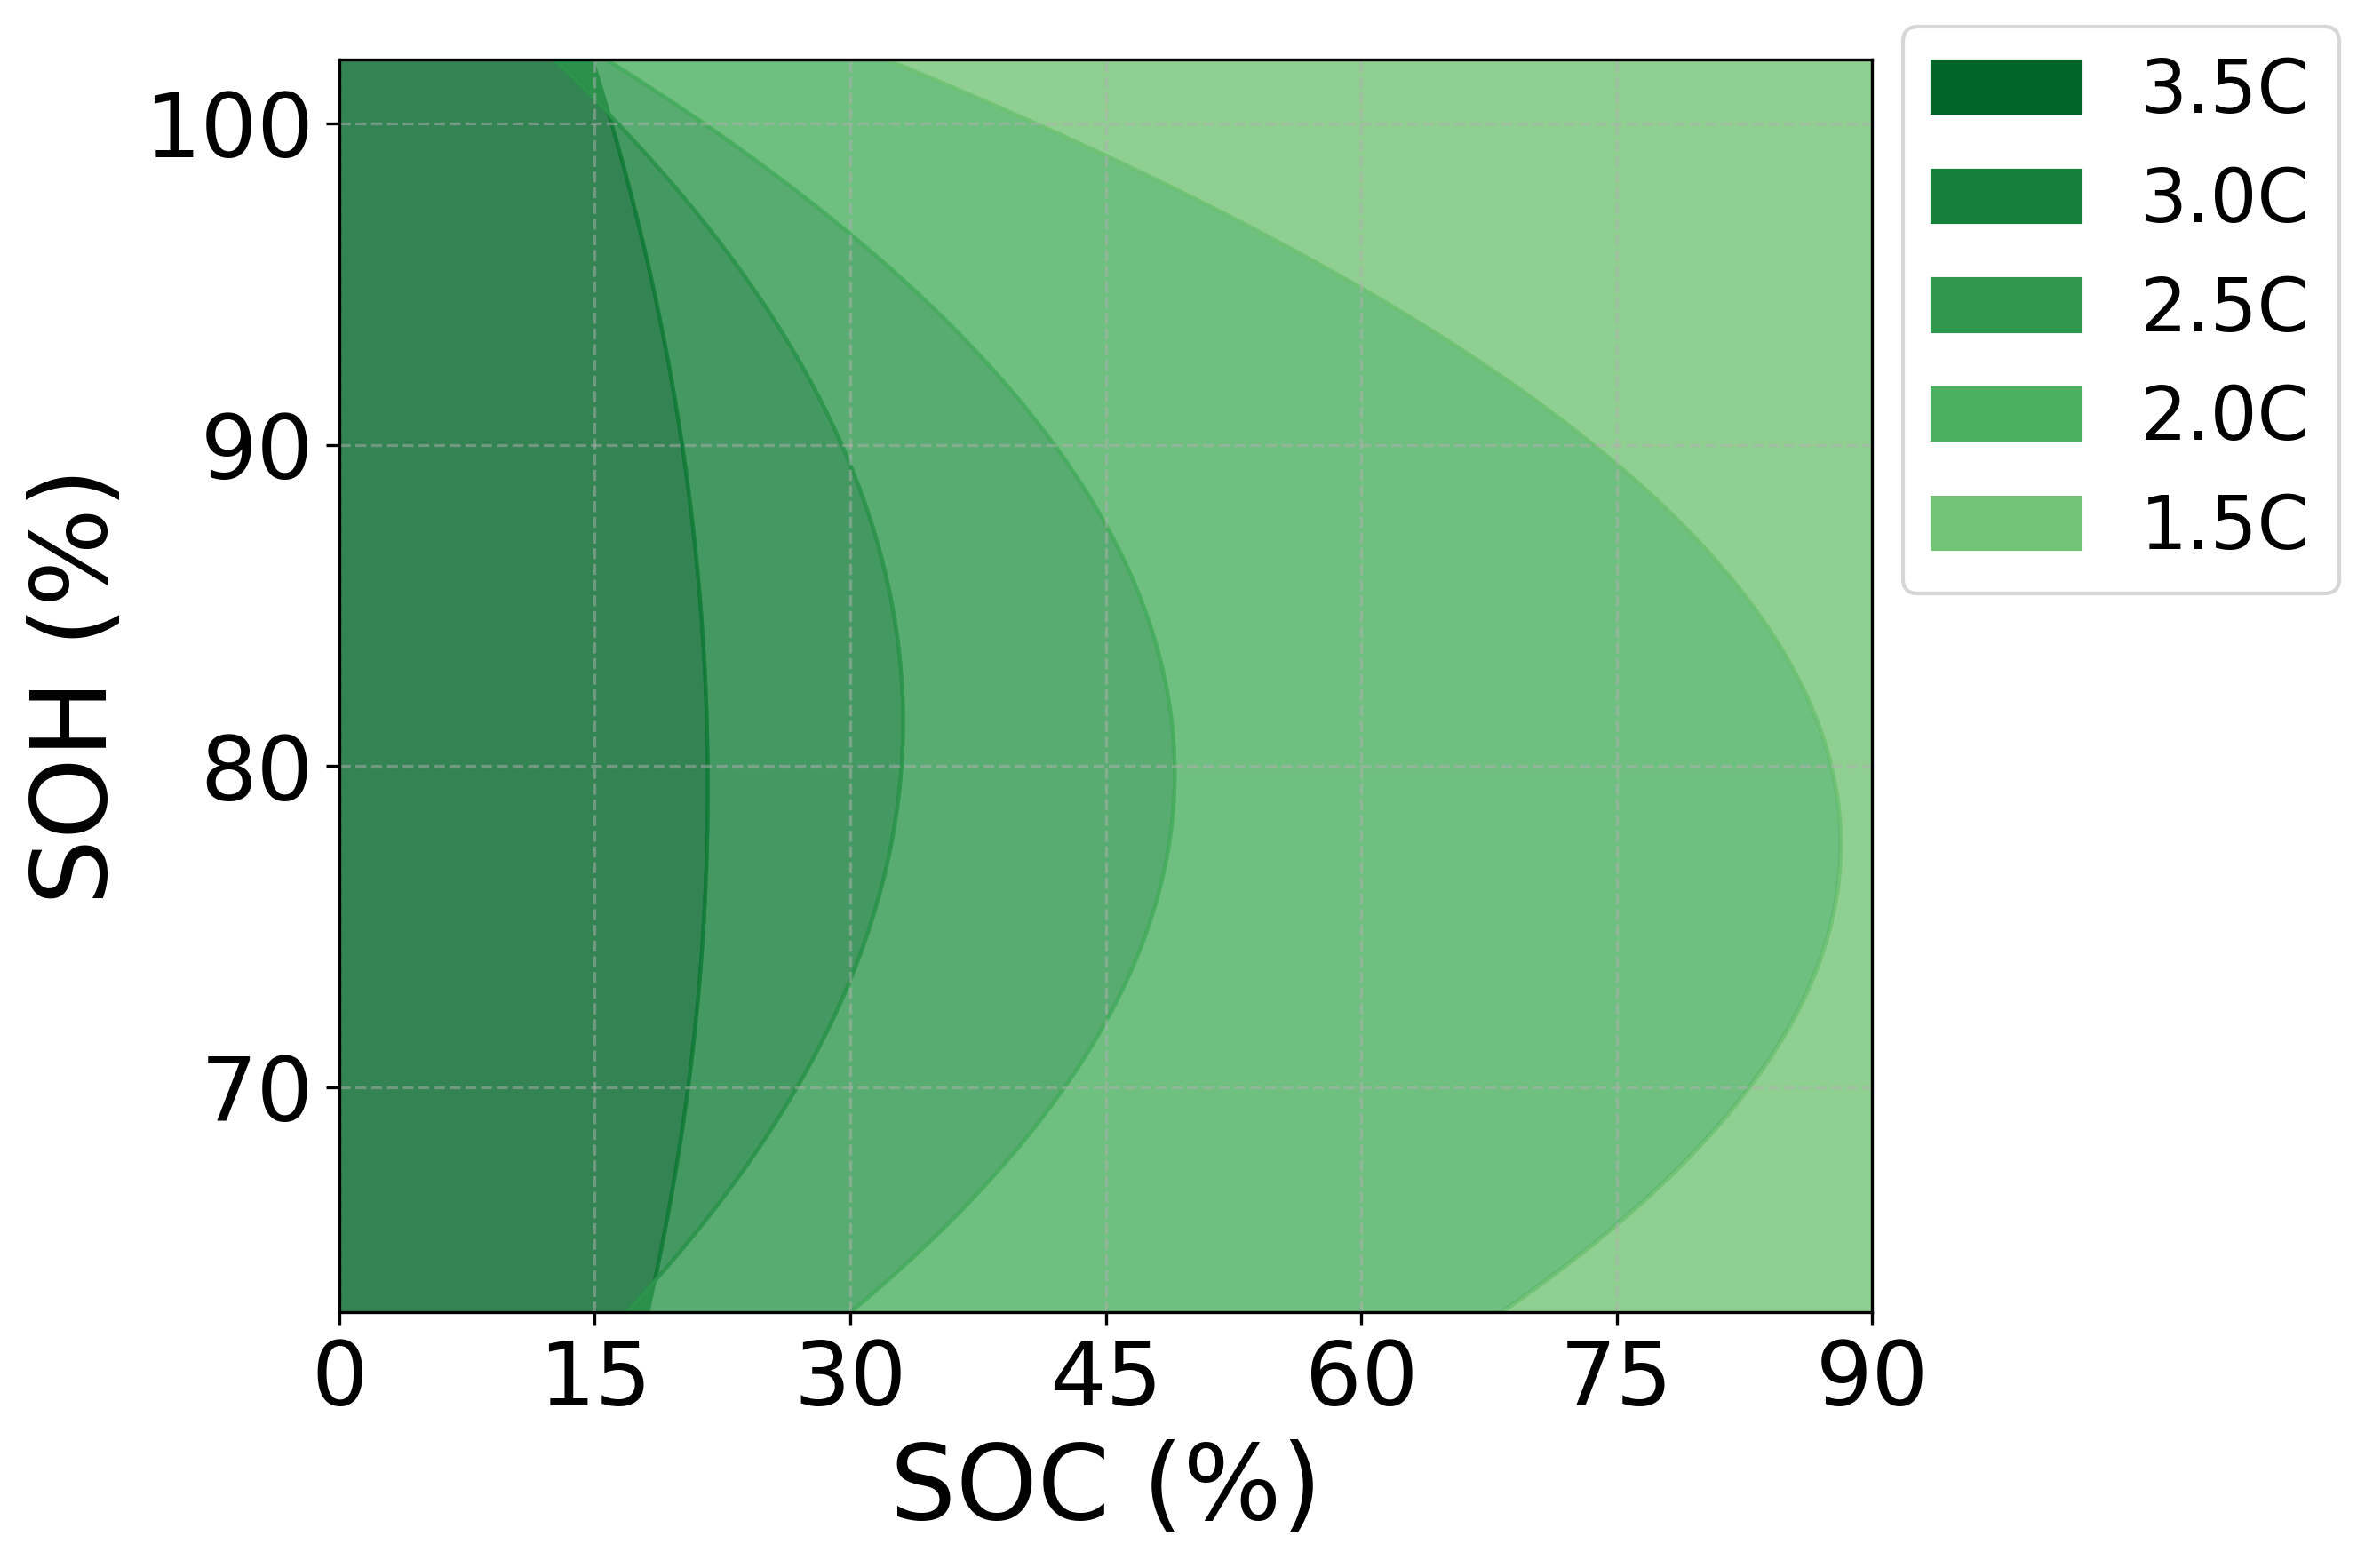

In [4]:
soc_table = build_soc_table(df_summary).dropna()
t_fit, soh_fit, curve_dict = fit_quadratic_boundaries(soc_table, t_fit=np.linspace(-0.5, 5.0, 200))

print("Average SOC values for each C-rate and SOH level:")
print(soc_table)

c_rates = np.sort(soc_table.index.values)[::-1]  # descending for layering
cmap = plt.get_cmap("Greens")
colors = [cmap(0.9), cmap(0.8), cmap(0.7), cmap(0.6), cmap(0.5)]

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# predefined C-rates
b1 = curve_dict[3.5]
b2 = curve_dict[3.0]
b3 = curve_dict[2.5]
b4 = curve_dict[2.0]

ax.fill_betweenx(soh_fit, 0, b1, color=colors[0], alpha=0.8)
ax.fill_betweenx(soh_fit, b1, b2, color=colors[1], alpha=0.8)
ax.fill_betweenx(soh_fit, b2, b3, color=colors[2], alpha=0.8)
ax.fill_betweenx(soh_fit, b3, b4, color=colors[3], alpha=0.8)

mask = soh_fit >= 60
ax.fill_betweenx(soh_fit[mask], b4[mask], 90, color=colors[4], alpha=0.8)

ax.set_xlabel("SOC (%)", fontsize=28)
ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
ax.set_ylabel("SOH (%)", fontsize=28)
ax.set_xlim(0, 90)
ax.set_ylim(63, 102)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(labelsize=24)

patches = [
    mpatches.Patch(color=colors[0], label="3.5C"),
    mpatches.Patch(color=colors[1], label="3.0C"),
    mpatches.Patch(color=colors[2], label="2.5C"),
    mpatches.Patch(color=colors[3], label="2.0C"),
    mpatches.Patch(color=colors[4], label="1.5C"),
]
ax.legend(handles=patches, fontsize=20, loc="center left", bbox_to_anchor=(1.02, 0.8), borderaxespad=0.0)

plt.tight_layout()
plt.show()


### Final Adaptive Charging Profiles

C:\Users\sin22002\AppData\Local\Temp\ipykernel_18240\207135929.py:37: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


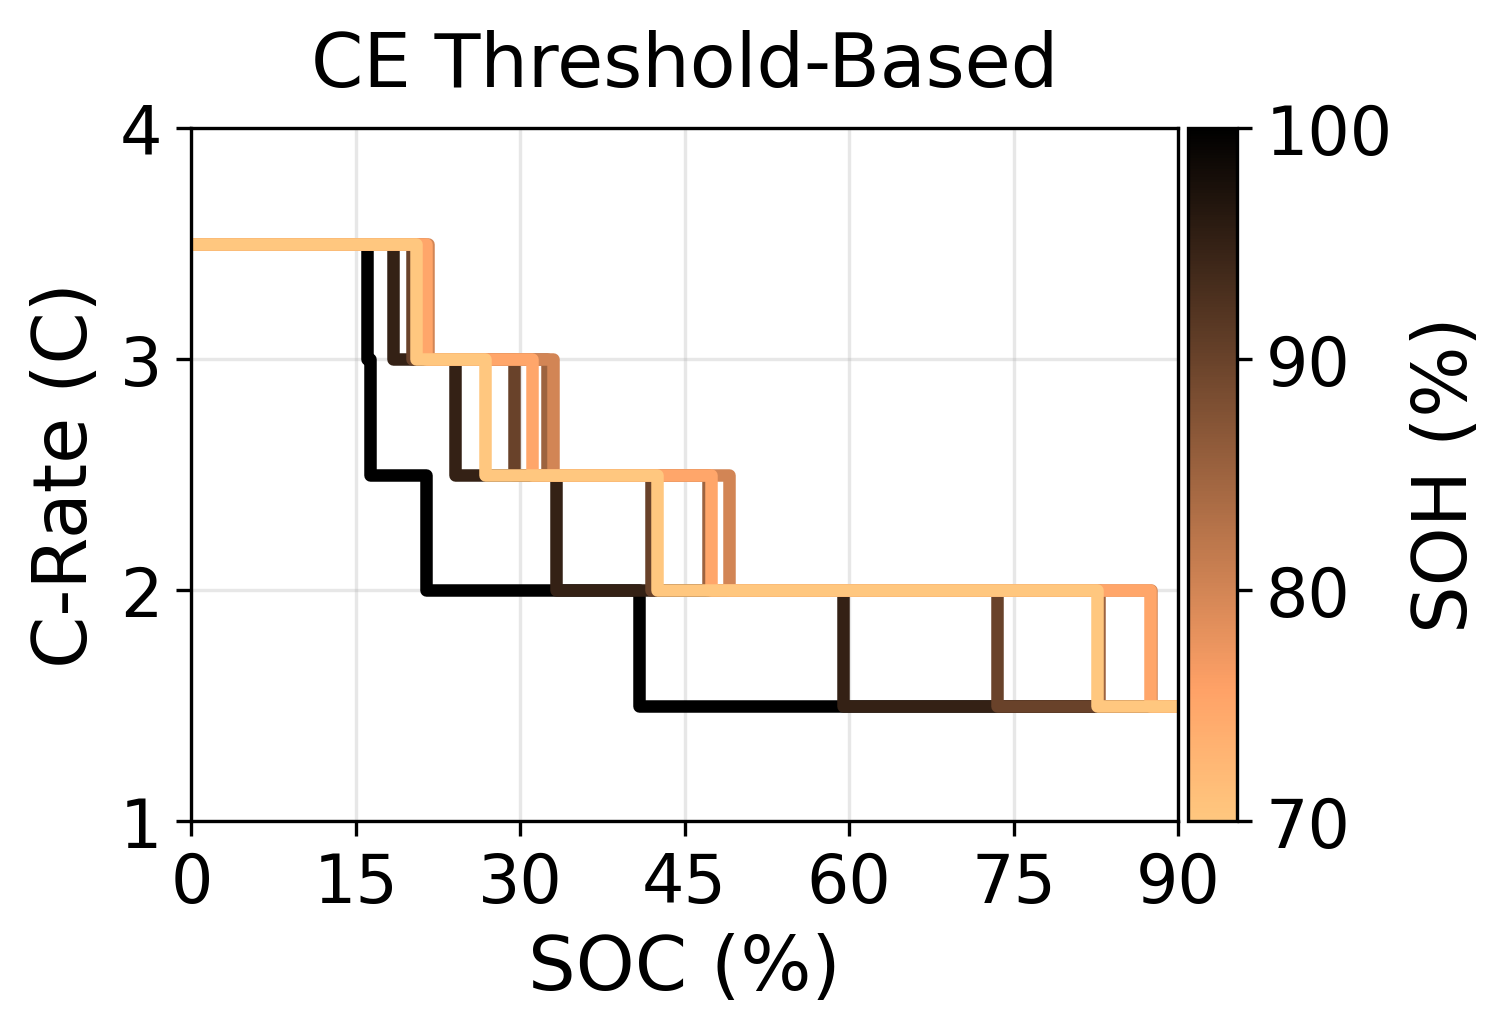

In [ ]:
from matplotlib.colors import Normalize
from utils.threshold_boundaries import build_profiles_over_soh

soh_levels = np.arange(100, 65, -5)  # 100..70
profiles = build_profiles_over_soh(soh_levels, soh_fit, curve_dict, final_soc=90, final_c_rate=1.5)

fig = plt.figure(figsize=(5, 3), dpi=300)
gs = fig.add_gridspec(1, 20)
ax = fig.add_subplot(gs[0, :17])
cax = fig.add_subplot(gs[0, 17])

cmap = plt.cm.copper_r
norm = Normalize(vmin=70, vmax=100)

for soh in soh_levels:
    p = profiles[float(soh)]
    ax.plot(p["SOC"], p["C-rate"], "-", color=cmap(norm(soh)), linewidth=3)

ax.set_xlabel("SOC (%)", fontsize=18)
ax.set_ylabel("C-Rate (C)", fontsize=18)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 90)
ax.set_ylim(1.0, 4.0)
ax.set_xticks(np.arange(0, 91, 15))
ax.set_title("CE Threshold-Based", fontsize=18, pad=10)
ax.tick_params(labelsize=16)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("SOH (%)", fontsize=18)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()


### Single Adapted Profile at a Given SOH

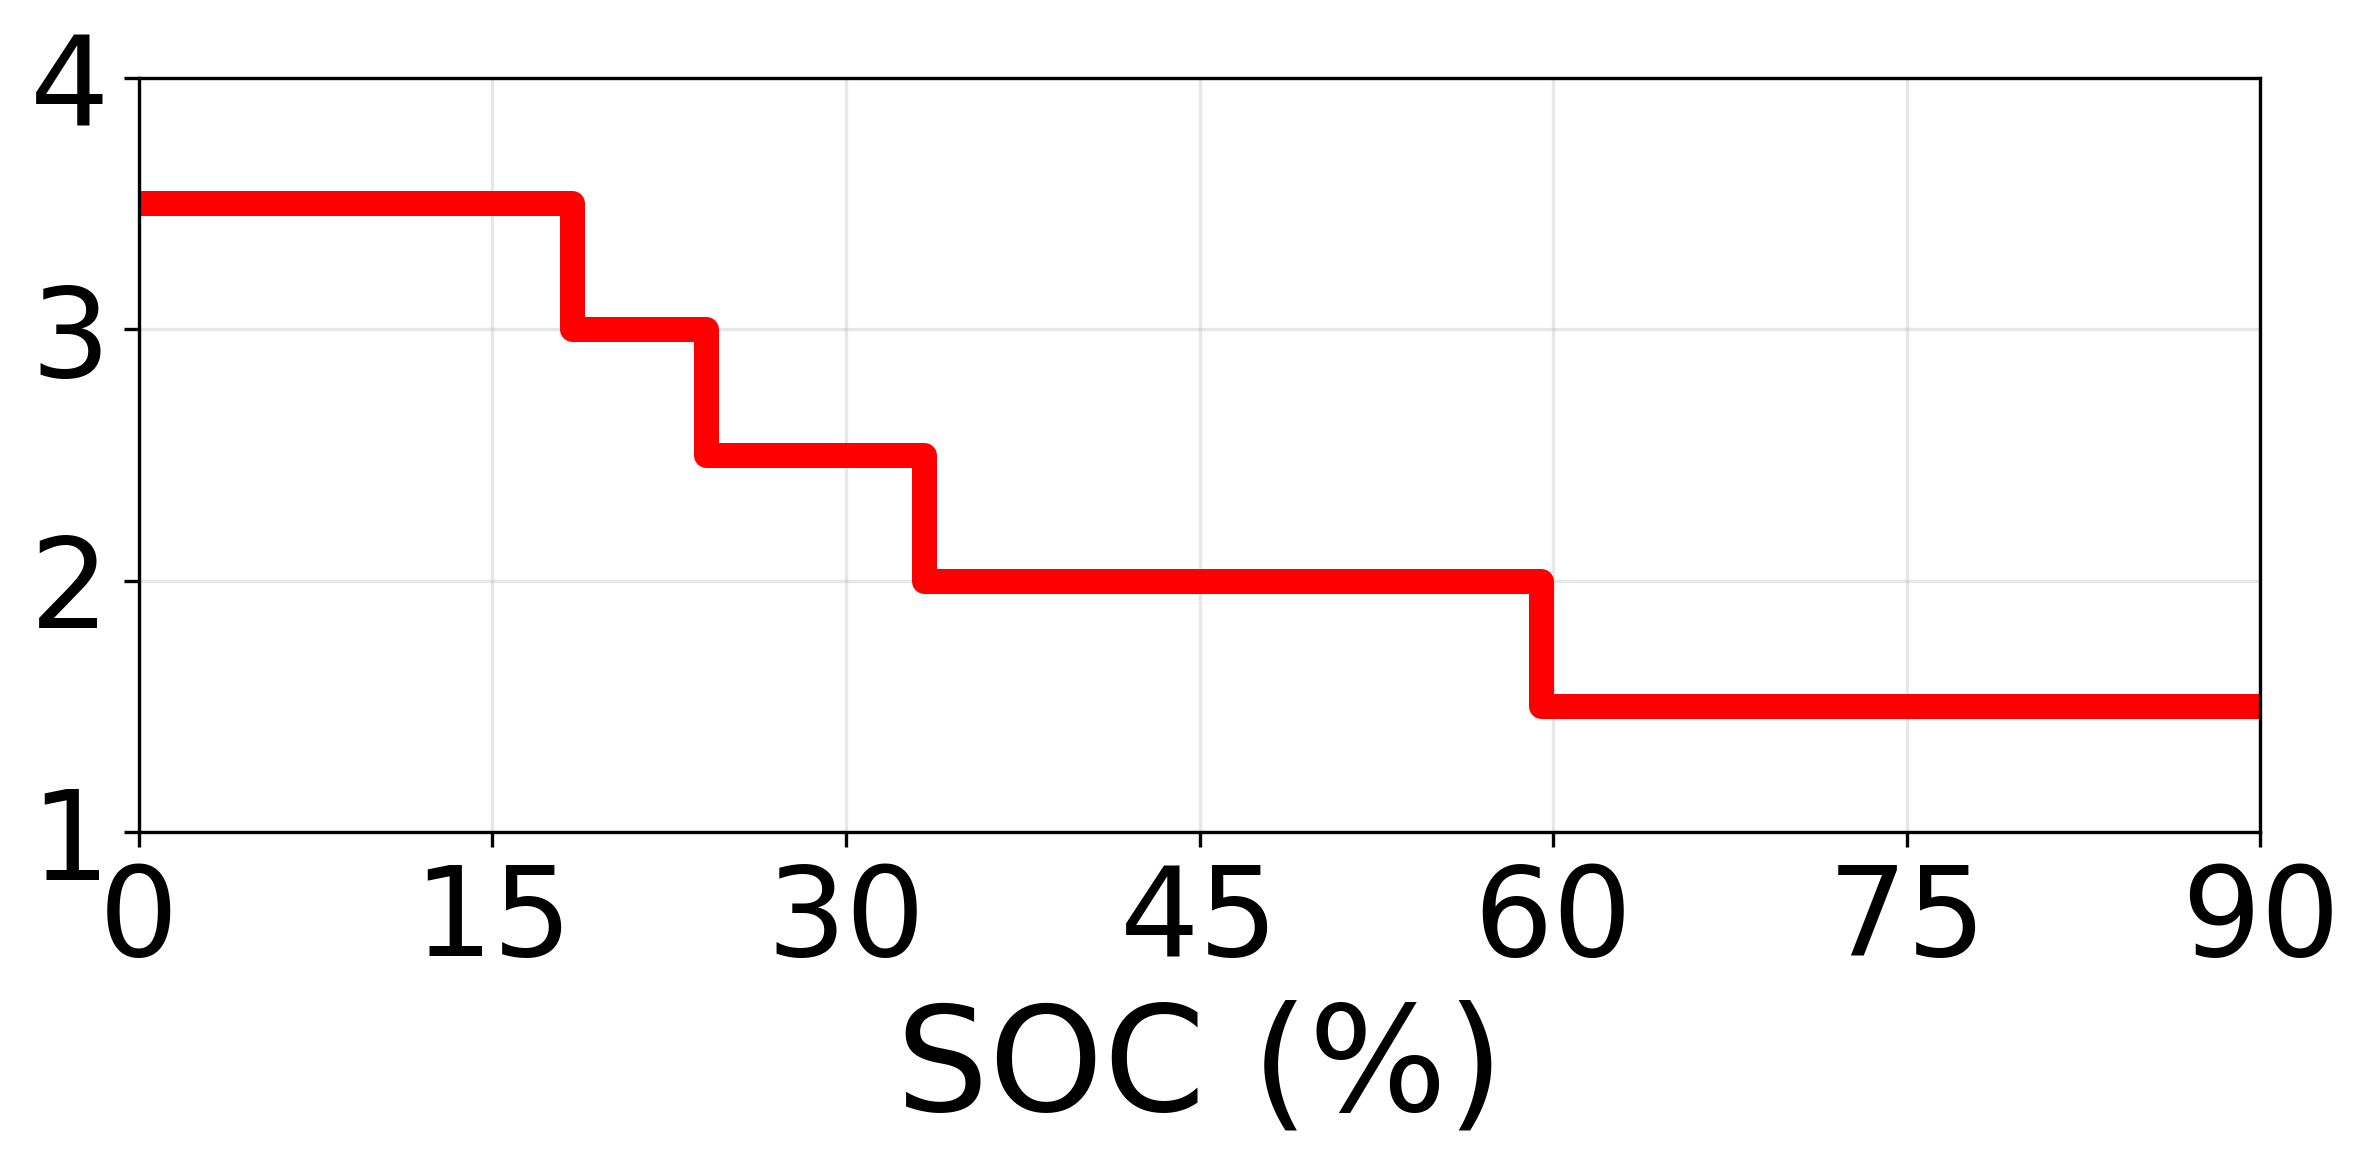

In [9]:
from utils.threshold_boundaries import profile_at_soh

p = profile_at_soh(95, soh_fit, curve_dict, final_soc=90, final_c_rate=1.5)

fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
ax.plot(p["SOC"], p["C-rate"], "r-", linewidth=6)

ax.set_xlabel("SOC (%)", fontsize=35)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 90)
ax.set_ylim(1, 4)
ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
ax.tick_params(labelsize=30)

plt.tight_layout()
plt.show()
